# Scaling analysis of how long it takes the neopawn to eat all of the pieces of food.

In [2]:
import sys
import os
import importlib

notebook_dir = r"c:\Users\benja\Documents\GitHub\Drunken_Chess_Pieces"
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

import NeoPawn_scaling_numpy as NeoPawn_scaling
importlib.reload(NeoPawn_scaling)
from NeoPawn_scaling_numpy import time_finder

import matplotlib.pyplot as plt

## Naive approach
Notice how the occasional failure just completely blows up the variance and pushes the mean up.

In [110]:
N = 5
M = 10
num_trials = 1000

def naive_average_time(num_trials, N, M, max_steps=10000):
    total_time = 0
    total_squared_time = 0
    failure = 0
    for _ in range(num_trials):
        steps, failure_to_finish = time_finder(N, M, max_steps)
        if failure_to_finish:
            failure += 1
        total_time += steps
        total_squared_time += (steps ** 2)

    average_time = total_time / (num_trials)
    variance = (total_squared_time / num_trials) - (average_time ** 2)
    std_dev = variance ** 0.5
    return average_time, std_dev, failure

print(naive_average_time(num_trials, N, M))

(1655.241, 3655.6251491255225, 161)


## Getting rid of failures
We don't count a run if it fails to get there after max_steps, which is typically huge anyway.

In [111]:
N = 5
M = 10
num_trials = 1000

def average_time(num_trials, N, M, max_steps=10000):
    total_time = 0
    total_squared_time = 0
    failure = 0
    for _ in range(num_trials):
        steps, failure_to_finish = time_finder(N, M, max_steps)
        if failure_to_finish:
            failure += 1
        else:
            total_time += steps
            total_squared_time += (steps ** 2)

    average_time = total_time / (num_trials - failure)
    variance = (total_squared_time / (num_trials - failure)) - (average_time ** 2)
    std_dev = variance ** 0.5
    return average_time, std_dev, failure

print(average_time(num_trials, N, M))

(51.2436974789916, 32.93482831989112, 167)


# Lets change the number of M around a bit...

In [118]:
N = 5
num_trials = 1000

m_values = [1, 3, 5, 7, 10, 13, 15]
times = []
std_devs = []
failures = []
for m in m_values:
    avg_time, std_dev, failure = average_time(num_trials, N, m, max_steps=10000)
    times.append(avg_time)
    std_devs.append(std_dev)
    failures.append(failure)


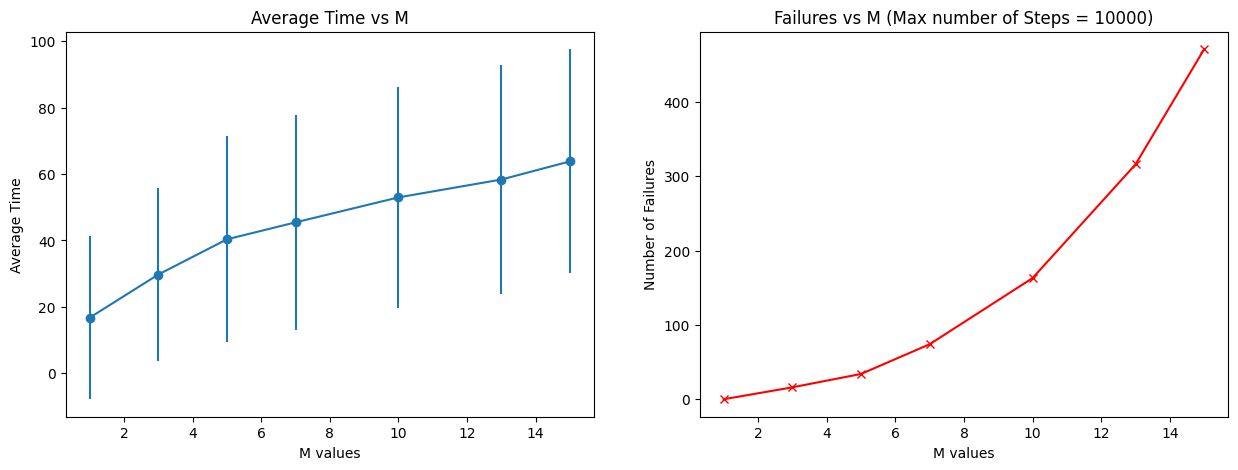

In [119]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.errorbar(m_values, times, yerr=std_devs, marker='o')
plt.xlabel('M values')
plt.ylabel('Average Time')
plt.title('Average Time vs M')


plt.subplot(1, 2, 2)
plt.plot(m_values, failures, marker='x',color='red')
plt.xlabel('M values')
plt.ylabel('Number of Failures')
plt.title('Failures vs M (Max number of Steps = 10000)')
plt.show()

# Now let us do it in cpp and take another look
More trials pending...

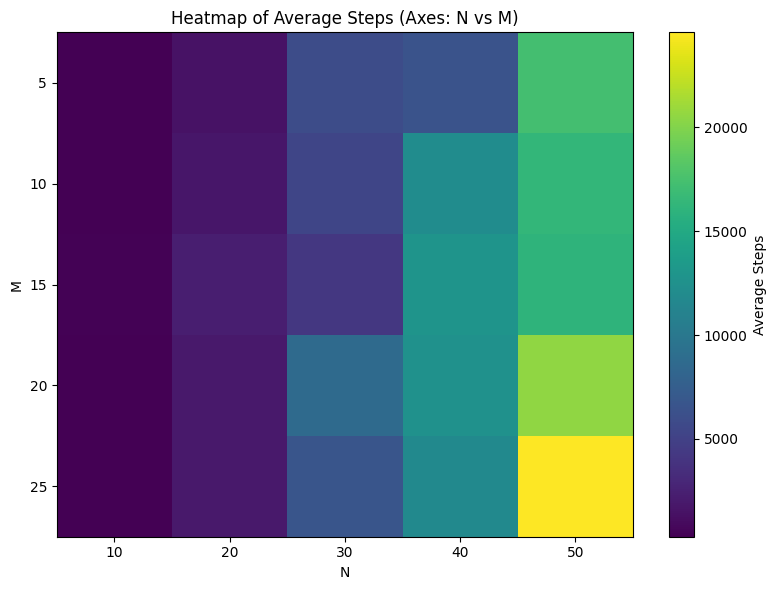

In [3]:
import pandas as pd
from io import StringIO
import numpy as np

df = pd.read_csv('data/cleaned_simulation_results.csv')

pivot = df.pivot(index="M", columns="N", values="Average_Steps")

plt.figure(figsize=(8,6))
plt.imshow(pivot, aspect='auto')
plt.colorbar(label="Average Steps")

plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
plt.yticks(np.arange(len(pivot.index)), pivot.index)

plt.xlabel("N")
plt.ylabel("M")
plt.title("Heatmap of Average Steps (Axes: N vs M)")

plt.tight_layout()
plt.show()


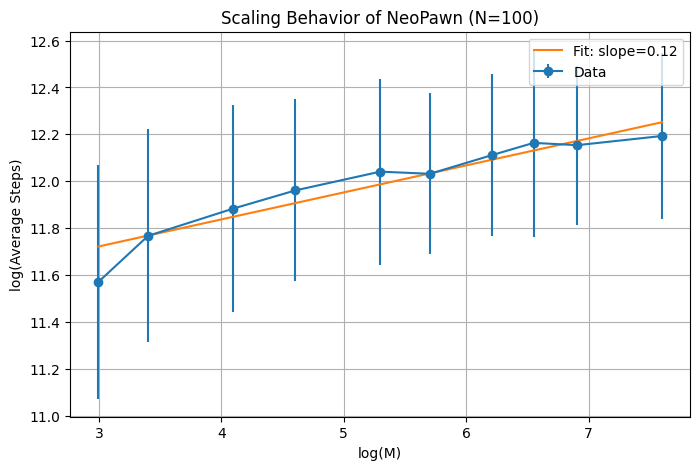

In [22]:
import pandas as pd
from scipy.optimize import curve_fit

df = pd.read_csv('data/ConstantN100.csv')
df.drop(columns=['max_steps'], inplace=True, errors='ignore')
df.drop(columns=['failed_to_finish'], inplace=True, errors='ignore')
# we know that N = 100 for all of these so let's drop that column too
df.drop(columns=['N'], inplace=True, errors='ignore')


agg = df.groupby('M')['steps_taken'].agg(['mean', 'std', 'count']).reset_index()
agg = agg.rename(columns={'mean': 'avg_steps', 'std': 'std_steps', 'count': 'n_runs'})

log_m = np.log(agg['M'])
log_steps = np.log(agg['avg_steps'])
log_steps_err = agg['std_steps'] / agg['avg_steps']

def func(x, m, c):
    return m * x + c

m, c = curve_fit(func, log_m, log_steps, sigma=log_steps_err)
x_fit = np.linspace(min(log_m), max(log_m), 100)
y_fit = func(x_fit, *m)

plt.figure(figsize=(8,5))
plt.errorbar(log_m, log_steps, yerr= log_steps_err, marker='o', linestyle='-', label='Data')
plt.plot(x_fit, y_fit, label=f'Fit: slope={m[0]:.2f}')
plt.xlabel('log(M)')
plt.ylabel('log(Average Steps)')
plt.title('Scaling Behavior of NeoPawn (N=100)')
plt.legend()
plt.grid(True)
plt.show()

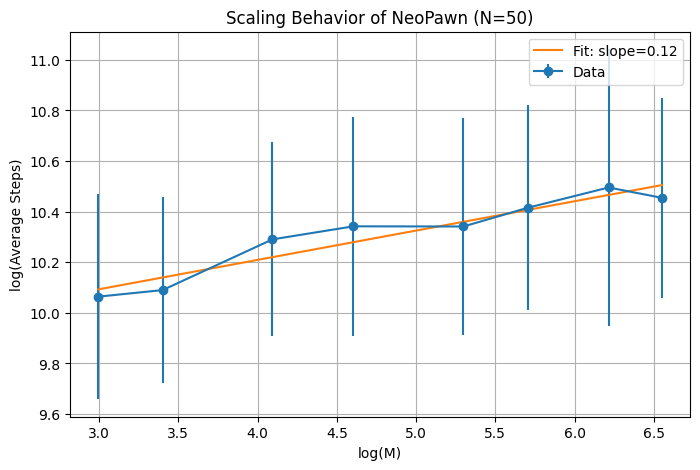

slope = 0.1160 +/- 0.1194 (95% CI: -0.1762 to 0.4082)


In [26]:
df = pd.read_csv('data/ConstantN50.csv')
df.drop(columns=['max_steps'], inplace=True, errors='ignore')
df.drop(columns=['failed_to_finish'], inplace=True, errors='ignore')
# we know that N = 50 for all of these so let's drop that column too
df.drop(columns=['N'], inplace=True, errors='ignore')


agg = df.groupby('M')['steps_taken'].agg(['mean', 'std', 'count']).reset_index()
agg = agg.rename(columns={'mean': 'avg_steps', 'std': 'std_steps', 'count': 'n_runs'})

log_m = np.log(agg['M'])
log_steps = np.log(agg['avg_steps'])
log_steps_err = agg['std_steps'] / agg['avg_steps']

def func(x, m, c):
    return m * x + c

m, c = curve_fit(func, log_m, log_steps, sigma=log_steps_err)
x_fit = np.linspace(min(log_m), max(log_m), 100)
y_fit = func(x_fit, *m)

plt.figure(figsize=(8,5))
plt.errorbar(log_m, log_steps, yerr= log_steps_err, marker='o', linestyle='-', label='Data')
plt.plot(x_fit, y_fit, label=f'Fit: slope={m[0]:.2f}')
plt.xlabel('log(M)')
plt.ylabel('log(Average Steps)')
plt.title('Scaling Behavior of NeoPawn (N=50)')
plt.legend()
plt.grid(True)
plt.show()

from scipy.stats import t


# Fit and return covariance. Use absolute_sigma=True because you pass sigma.
popt, pcov = curve_fit(func, log_m, log_steps, sigma=log_steps_err, absolute_sigma=True)
# Best-fit parameters and 1-sigma errors
slope, intercept = popt
slope_err, intercept_err = np.sqrt(np.diag(pcov))
# 95% confidence interval (two-sided) using t-distribution
n = len(log_m)
p = len(popt)
df = max(0, n - p)
if df > 0:
    tval = t.ppf(0.975, df)
else:
    tval = 1.96  # fallback: normal approx
slope_ci = (slope - tval * slope_err, slope + tval * slope_err)


print(f"slope = {slope:.4f} +/- {slope_err:.4f} (95% CI: {slope_ci[0]:.4f} to {slope_ci[1]:.4f})")

# What is the distribution?
I ran the following code on the new MPI version of the code.
That data is in data/example_distribution.csv

N: 15
M: 10
Max steps: 20000
Total simulations: 1000
MPI processes: 4
Failures: 3

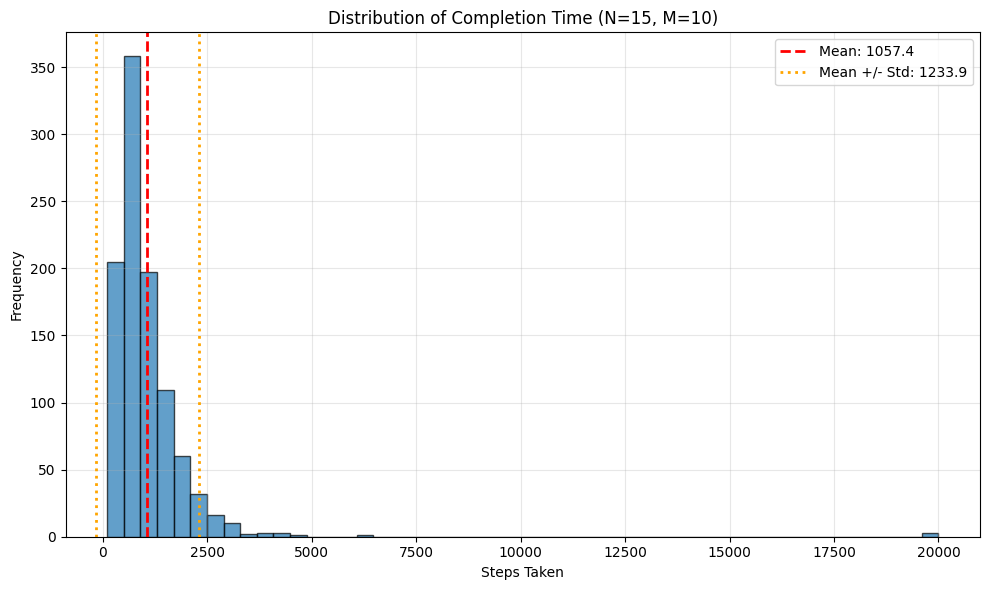


Mean: 1057.38
Number of samples: 1000
Std Dev: 1233.90
Min: 103
Max: 20000, note that there is a cutoff at 20000 steps
Median: 828.50


In [5]:
import numpy as np
import matplotlib.pyplot as plt

data = np.genfromtxt('data/example_distribution.csv', delimiter=',')

plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Steps Taken')
plt.ylabel('Frequency')
plt.title('Distribution of Completion Time (N=15, M=10)')
plt.grid(True, alpha=0.3)

mean_steps = np.mean(data)
std_steps = np.std(data)
plt.axvline(mean_steps, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_steps:.1f}')
plt.axvline(mean_steps - std_steps, color='orange', linestyle=':', linewidth=2, label=f'Mean +/- Std: {std_steps:.1f}')
plt.axvline(mean_steps + std_steps, color='orange', linestyle=':', linewidth=2)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nMean: {mean_steps:.2f}")
print(f"Number of samples: {len(data)}")
print(f"Std Dev: {std_steps:.2f}")
print(f"Min: {np.min(data):.0f}")
print(f"Max: {np.max(data):.0f}, note that there is a cutoff at 20000 steps")
print(f"Median: {np.median(data):.2f}")

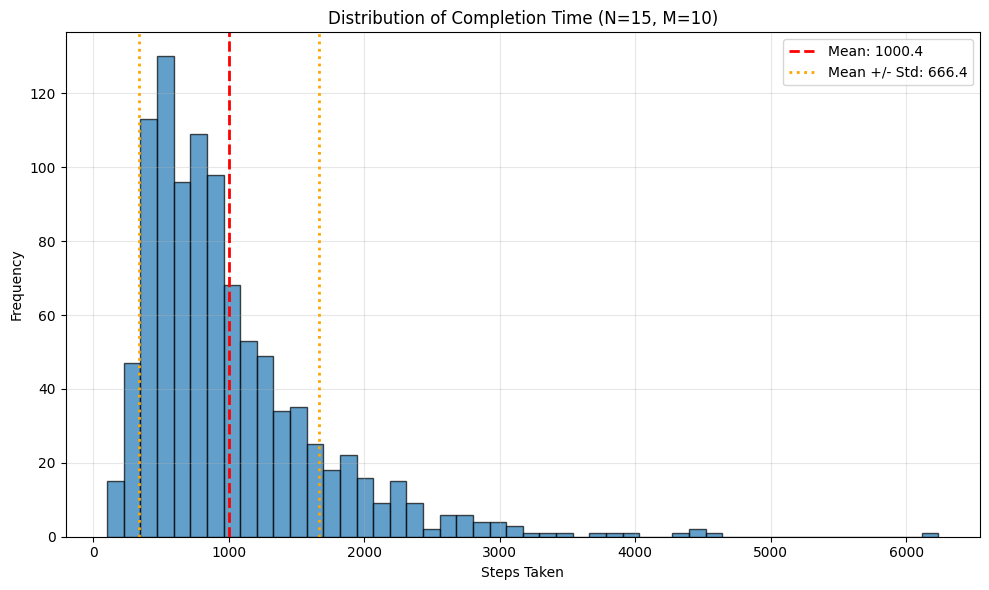


Mean: 1000.39
Number of samples: 997
Std Dev: 666.43
Min: 103
Max: 6237, note that there is a cutoff at 20000 steps
Median: 826.00


In [6]:
# Now let's remove the data points at the cutoff (20000 steps)
data = data[data < 20000]

plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Steps Taken')
plt.ylabel('Frequency')
plt.title('Distribution of Completion Time (N=15, M=10)')
plt.grid(True, alpha=0.3)

mean_steps = np.mean(data)
std_steps = np.std(data)
plt.axvline(mean_steps, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_steps:.1f}')
plt.axvline(mean_steps - std_steps, color='orange', linestyle=':', linewidth=2, label=f'Mean +/- Std: {std_steps:.1f}')
plt.axvline(mean_steps + std_steps, color='orange', linestyle=':', linewidth=2)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nMean: {mean_steps:.2f}")
print(f"Number of samples: {len(data)}")
print(f"Std Dev: {std_steps:.2f}")
print(f"Min: {np.min(data):.0f}")
print(f"Max: {np.max(data):.0f}, note that there is a cutoff at 20000 steps")
print(f"Median: {np.median(data):.2f}")